In [1]:
import numpy as np
from skimage import io
from glob import glob
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import confusion_matrix
import random
import itertools
# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
FOLDER = "../input/potsdamvaihingen/"

LABELS = ["roads", "buildings", "low veg.", "trees", "cars", "clutter"] # Label names
N_CLASSES = len(LABELS) # Number of classes

DATASET = 'Potsdam'

if DATASET == 'Potsdam':
    MAIN_FOLDER = FOLDER
    DATA_FOLDER = MAIN_FOLDER + '3_ortho_irrg/3_Ortho_IRRG/top_potsdam_{}_IRRG.tif'
    DSM_FOLDER = MAIN_FOLDER + '1_dsm/1_DSM/dsm_potsdam_0{}.tif'
    NDSM_FOLDER = MAIN_FOLDER + '1_dsm_normalisation/1_DSM_normalisation/dsm_potsdam_0{}_normalized_lastools.jpg'
    LABEL_FOLDER = '../input/label-all-potsdam-vaihingen/5_labels_all/top_potsdam_{}_label.tif'
    ERODED_FOLDER = '../input/label-all-potsdam-vaihingen/5_labels_all_noboundary/5_labels_for_participants_no_boundary/5_Labels_for_participants_no_Boundary/top_potsdam_{}_label_noBoundary.tif'    

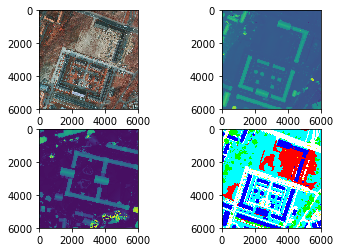

Ground truth in numerical format has shape (6000,6000) : 
 [[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]


In [3]:
# ISPRS color palette
# Let's define the standard ISPRS color palette

palette = {0 : (255, 255, 255), # Impervious surfaces (white)
           1 : (0, 0, 255),     # Buildings (blue)
           2 : (0, 255, 255),   # Low vegetation (cyan)
           3 : (0, 255, 0),     # Trees (green)
           4 : (255, 255, 0),   # Cars (yellow)
           5 : (255, 0, 0),     # Clutter (red)
           6 : (0, 0, 0)}       # Undefined (black)

invert_palette = {v: k for k, v in palette.items()}

def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    for c, i in palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
        arr_2d[m] = i

    return arr_2d

# We load one tile from the dataset and we display it
img = io.imread('../input/potsdamvaihingen/3_ortho_irrg/3_Ortho_IRRG/top_potsdam_2_10_IRRG.tif')
fig = plt.figure()
plt.subplot(2, 2, 1)
plt.imshow(img)

dsm = io.imread('../input/potsdamvaihingen/1_dsm/1_DSM/dsm_potsdam_02_10.tif')
plt.subplot(2, 2, 2)
plt.imshow(dsm)
#'2_12', '3_12', '5_12','6_11', '6_12', '7_08'
#['2_10', '2_11', '3_10', '3_11', '4_10', '4_11', '5_10', '6_7', '6_9', '6_10', '7_8', '7_9', '7_10', '7_11']
dsm = io.imread('../input/potsdamvaihingen/1_dsm_normalisation/1_DSM_normalisation/dsm_potsdam_03_11_normalized_lastools.jpg')
plt.subplot(2, 2, 3)
plt.imshow(dsm)

# We load the ground truth
gt = io.imread('../input/label-all-potsdam-vaihingen/5_labels_all/top_potsdam_2_10_label.tif')
plt.subplot(2, 2, 4)
plt.imshow(gt)
plt.show()

# We also check that we can convert the ground truth into an array format
array_gt = convert_from_color(gt)
print("Ground truth in numerical format has shape ({},{}) : \n".format(*array_gt.shape[:2]), array_gt)

In [4]:
all_images = ['2_10','2_11','2_12','2_13','2_14','3_10','3_11','3_12','3_13','3_14',
              '4_10','4_11','4_12','4_13','4_14','4_15','5_10','5_11','5_12','5_13',
              '5_14','5_15','6_7','6_8','6_9','6_10','6_11','6_12','6_13','6_14',
              '6_15','7_7','7_8','7_9','7_10','7_11','7_12','7_13']

In [5]:
def plot_pie(n_pixel):
    labels_ = ["roads {}", "buildings {}", "low veg. {}", "trees {}", "cars {}", "clutter{}"]
    colors = ['gray', 'blue', 'cyan', 'green', 'yellow', 'red']
    explode = (0,0,0,0,0,0)  # explode 1st slice
    
    total_pixel = np.sum(np.array(n_pixel))
    i = 0
    labels = []
    for l in labels_:
        labels.append(l.format(n_pixel[i]/total_pixel))
        i +=1
        
    # Plot
    plt.pie(n_pixel, explode=explode, labels=labels, colors=colors)
    plt.axis('equal')
    plt.show()

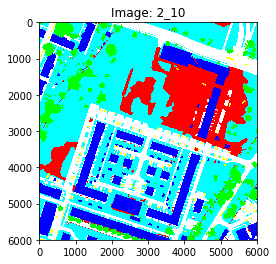

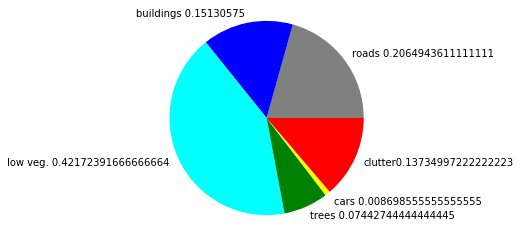

[7433797, 5447007, 15182061, 2679388, 313148, 4944599]


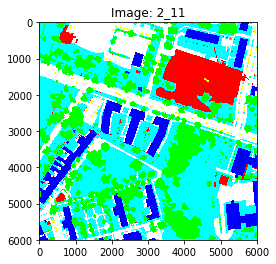

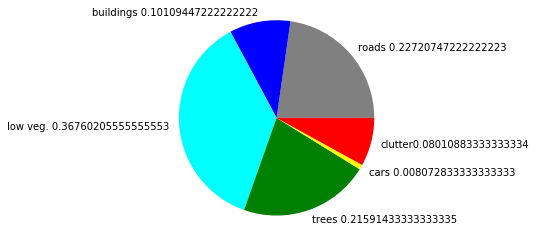

[8179469, 3639401, 13233674, 7772916, 290622, 2883918]


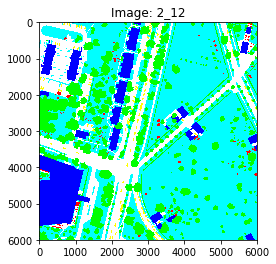

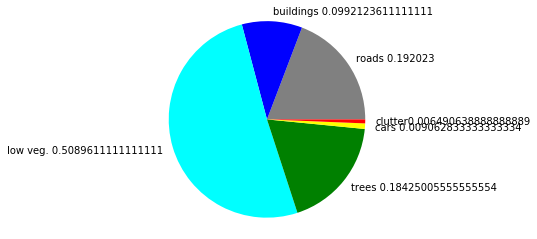

[6912828, 3571645, 18322600, 6633002, 326262, 233663]


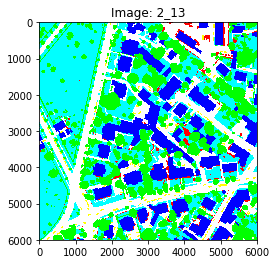

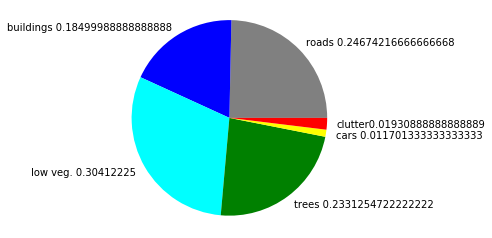

[8882718, 6659996, 10948401, 8392517, 421248, 695120]


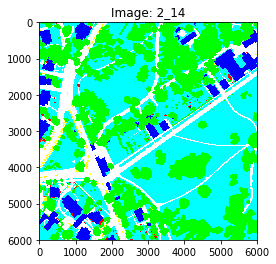

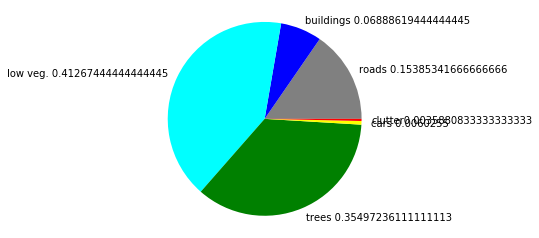

[5538723, 2479903, 14856280, 12779005, 216918, 129171]


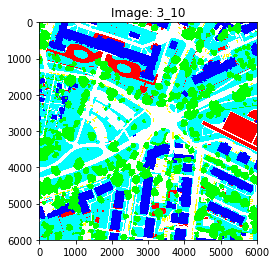

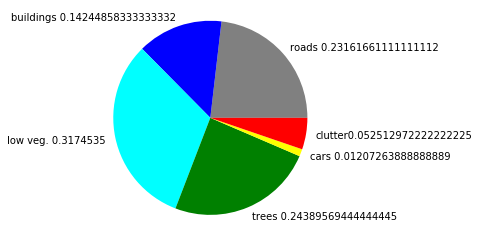

[8338198, 5128149, 11428326, 8780245, 434615, 1890467]


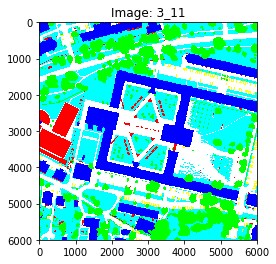

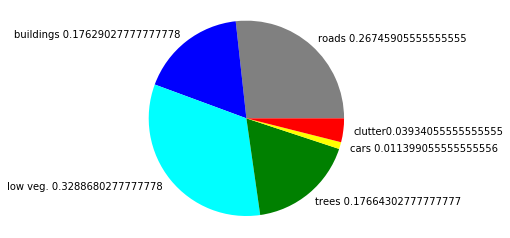

[9628526, 6346450, 11839249, 6359149, 410366, 1416260]


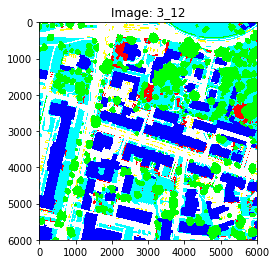

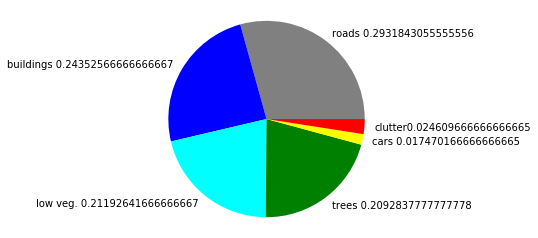

[10554635, 8766924, 7629351, 7534216, 628926, 885948]


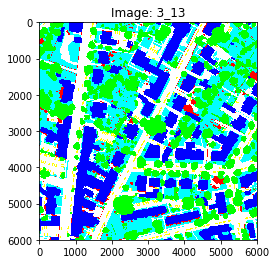

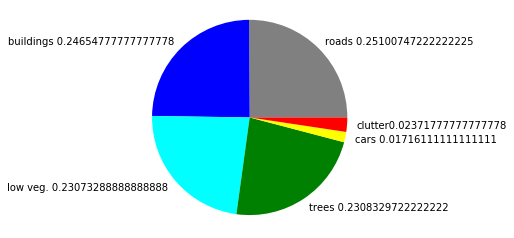

[9036269, 8875720, 8306384, 8309987, 617800, 853840]


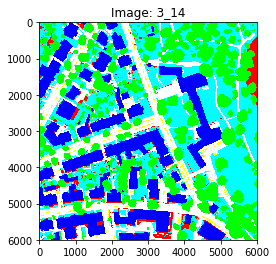

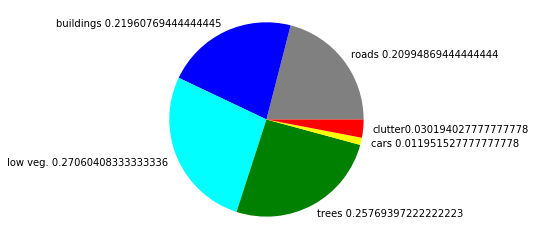

[7558153, 7905877, 9741747, 9276983, 430255, 1086985]


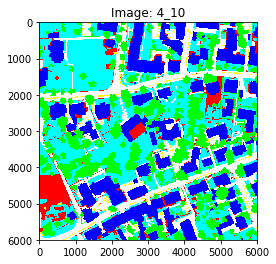

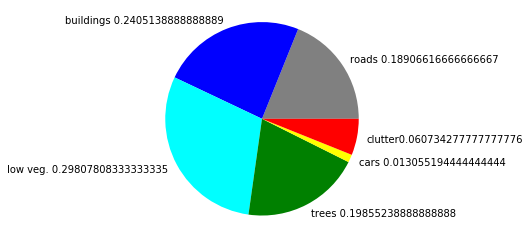

[6806382, 8658500, 10730811, 7147886, 469987, 2186434]


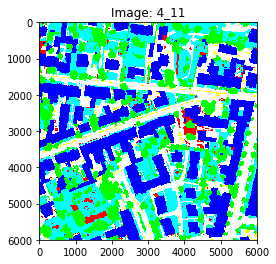

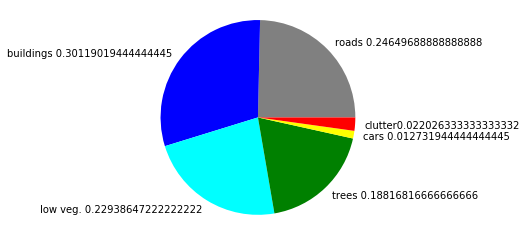

[8873888, 10842847, 8257913, 6774054, 458350, 792948]


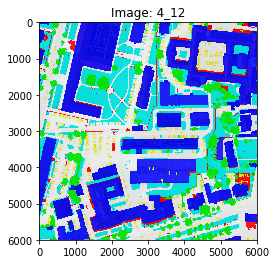

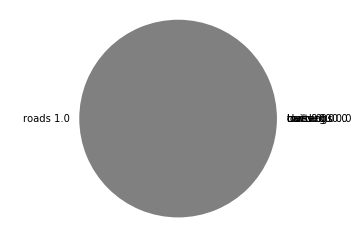

[36000000, 0, 0, 0, 0, 0]


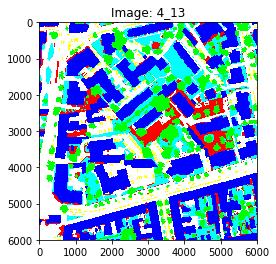

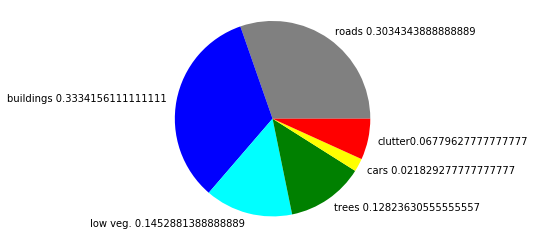

[10923638, 12002962, 5230373, 4616507, 785854, 2440666]


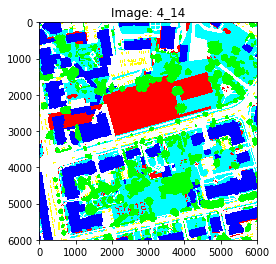

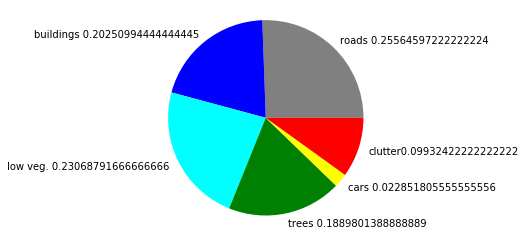

[9203255, 7290358, 8304765, 6803285, 822665, 3575672]


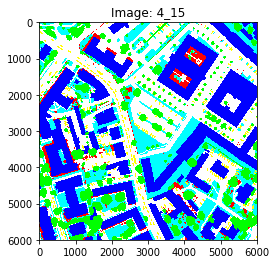

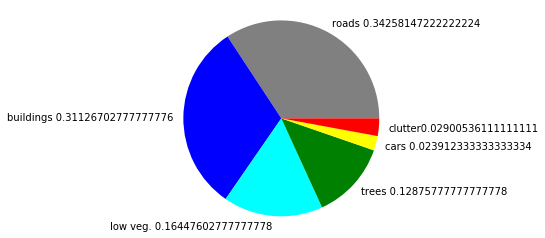

[12332933, 11205613, 5921137, 4635280, 860844, 1044193]


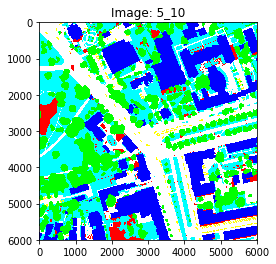

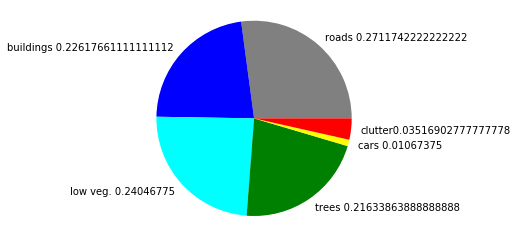

[9762272, 8142358, 8656839, 7788191, 384255, 1266085]


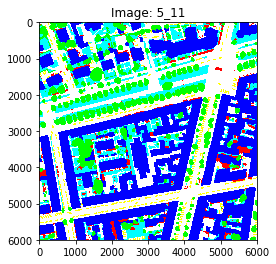

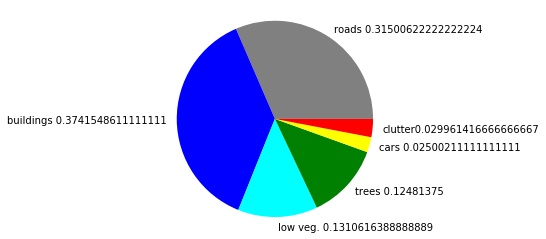

[11340224, 13469575, 4718219, 4493295, 900076, 1078611]


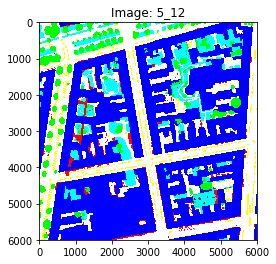

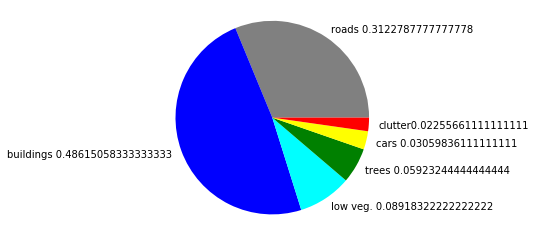

[11242036, 17501421, 3210596, 2132368, 1101541, 812038]


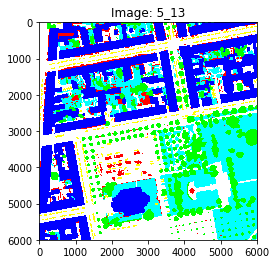

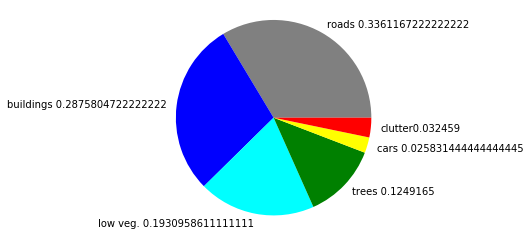

[12100202, 10352897, 6951451, 4496994, 929932, 1168524]


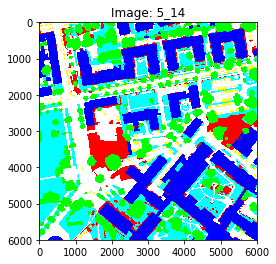

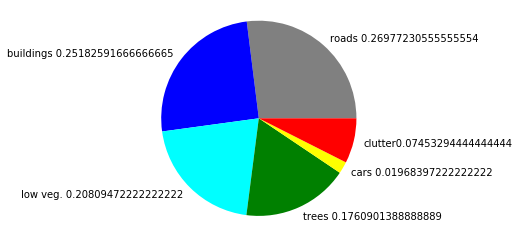

[9711803, 9065733, 7491410, 6339245, 708623, 2683186]


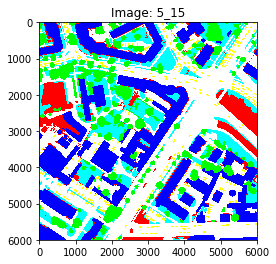

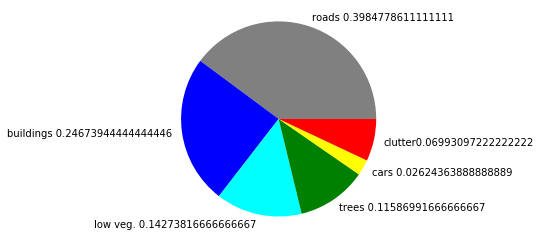

[14345203, 8882620, 5138574, 4171317, 944771, 2517515]


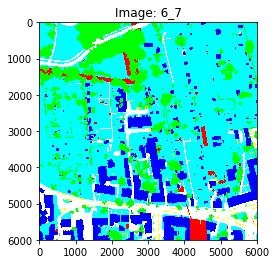

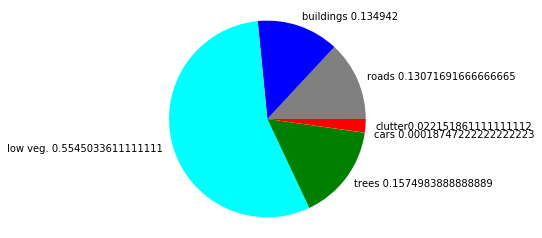

[4705809, 4857912, 19962121, 5669942, 6749, 797467]


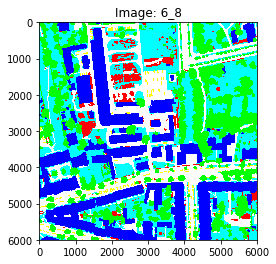

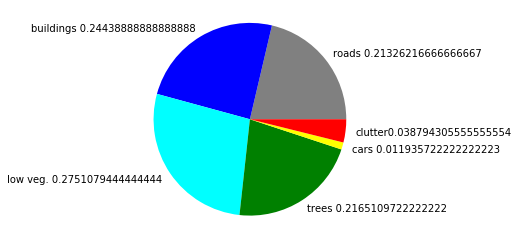

[7677438, 8798000, 9903886, 7794395, 429686, 1396595]


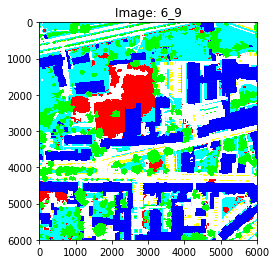

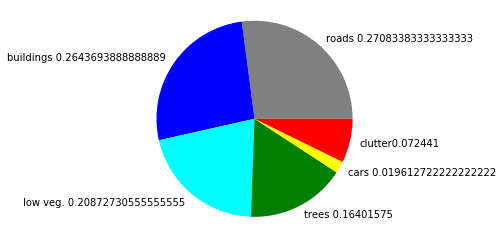

[9750018, 9517298, 7514183, 5904567, 706058, 2607876]


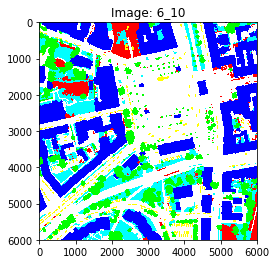

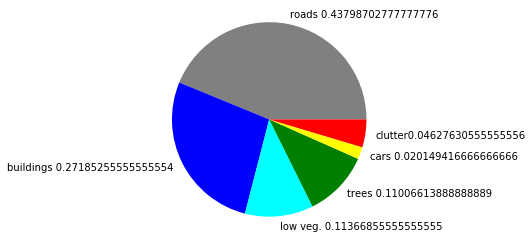

[15767533, 9786692, 4092068, 3962381, 725379, 1665947]


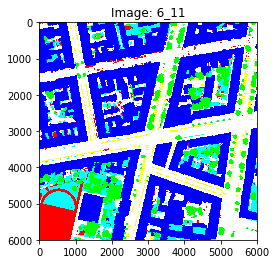

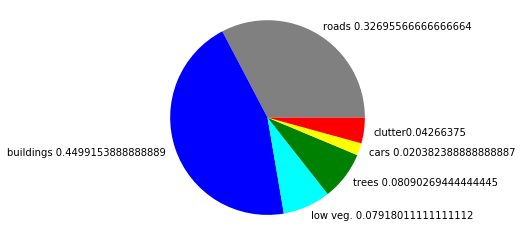

[11770404, 16196954, 2850484, 2912497, 733766, 1535895]


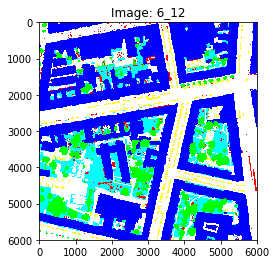

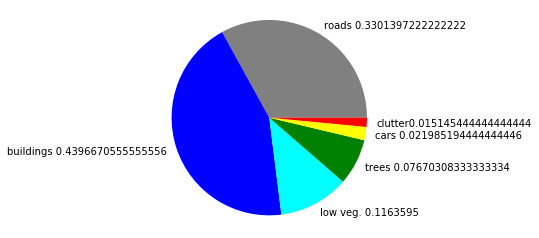

[11885030, 15828014, 4188942, 2761311, 791467, 545236]


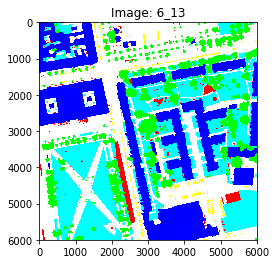

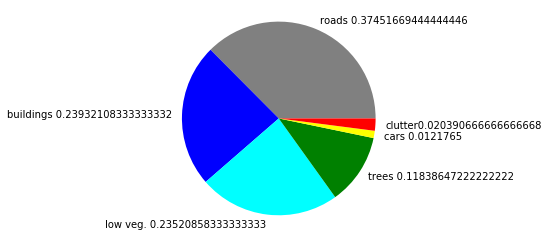

[13482601, 8615559, 8467509, 4261913, 438354, 734064]


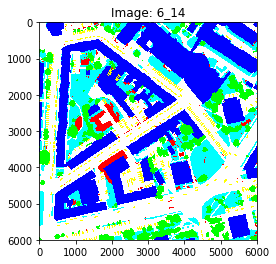

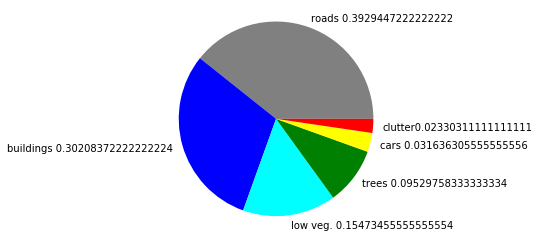

[14146010, 10875014, 5570444, 3430713, 1138907, 838912]


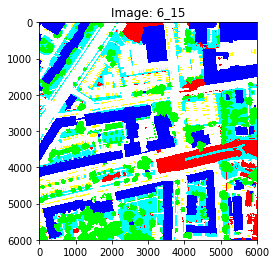

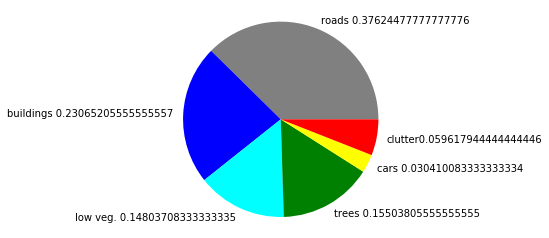

[13544812, 8303474, 5329335, 5581370, 1094763, 2146246]


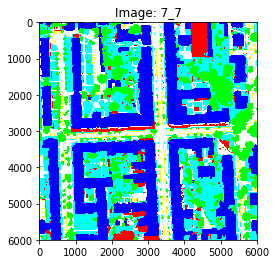

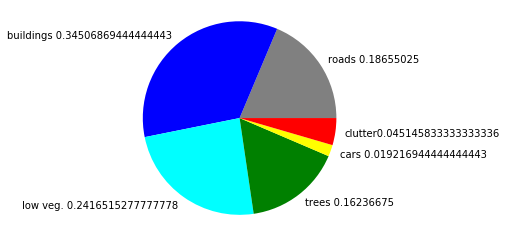

[6715809, 12422473, 8699455, 5845203, 691810, 1625250]


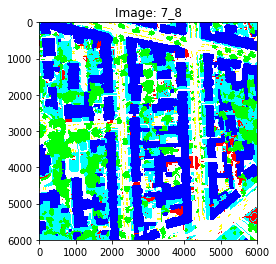

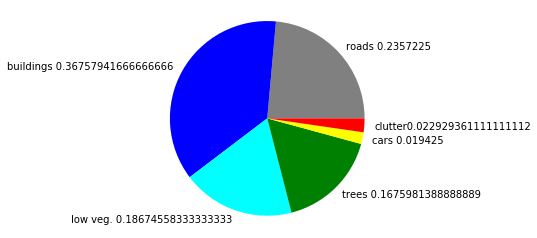

[8486010, 13232859, 6722841, 6033533, 699300, 825457]


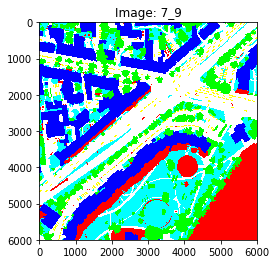

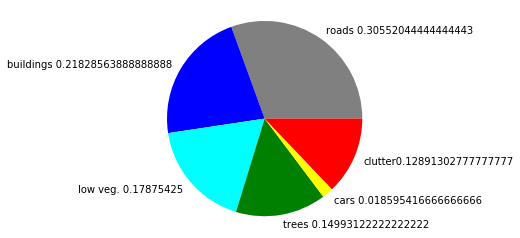

[10998736, 7858283, 6435153, 5397524, 669435, 4640869]


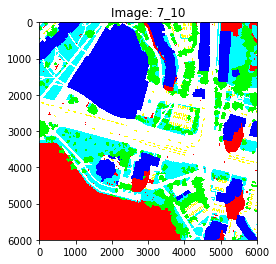

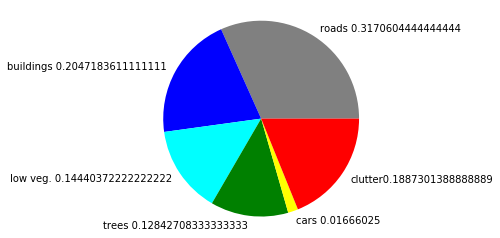

[11414176, 7369861, 5198534, 4623375, 599769, 6794285]


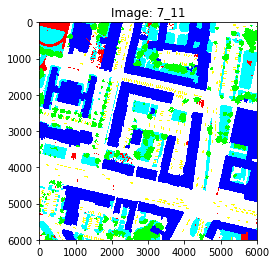

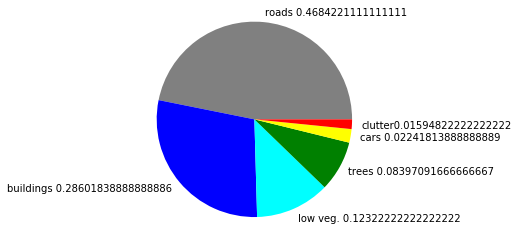

[16863196, 10296662, 4436000, 3022953, 807053, 574136]


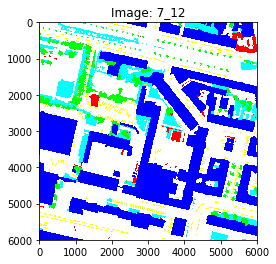

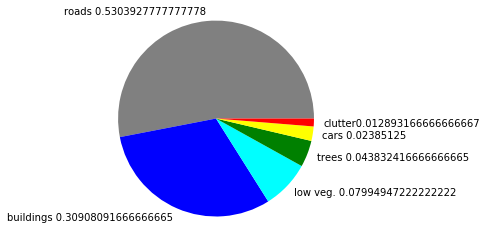

[19094140, 11126913, 2878181, 1577967, 858645, 464154]


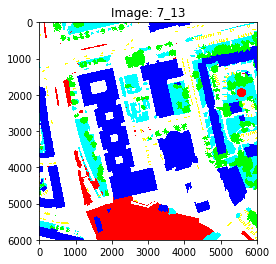

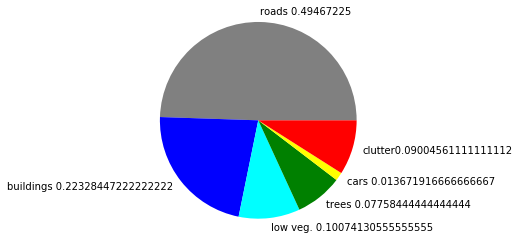

[17808201, 8038241, 3626687, 2793040, 492189, 3241642]


In [6]:
n_pixel_all = [0,0,0,0,0,0]
for img in all_images:
    gt = io.imread('../input/label-all-potsdam-vaihingen/5_labels_all/top_potsdam_{}_label.tif'.format(img))
    
    fig = plt.figure()
    plt.subplot(1, 1, 1)
    plt.imshow(gt)
    plt.title('Image: {}'.format(img))
    plt.show()
    
    array_gt = convert_from_color(gt)
    array_gt = array_gt.reshape(36000000)
    n_pixel = [0,0,0,0,0,0]
    for i in array_gt:
        n_pixel[i] += 1
        n_pixel_all[i] += 1 
    plot_pie(n_pixel)
    print(n_pixel)


Reading 38 images
[428815075, 339360165, 301975984, 209488514, 23340388, 65019874]


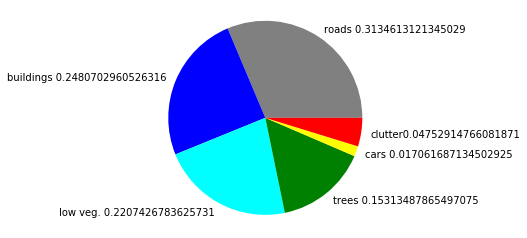

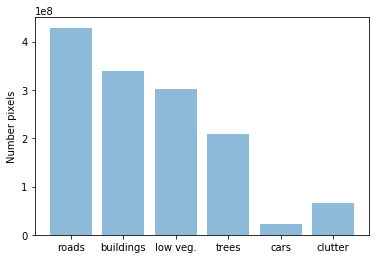

In [7]:
print('Reading {} images'.format(len(all_images)))
print(n_pixel_all)
plot_pie(n_pixel_all)

labels = ["roads", "buildings", "low veg.", "trees", "cars", "clutter"]
y_pos = np.arange(len(labels))
performance = n_pixel_all
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel('Number pixels')
 
plt.show()